In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import cv2
np.random.seed(42)

In [2]:
############ Load Voronoi Images ###########
data = np.load('voronoi_imgs.npy', allow_pickle=True)
x_train = data[0]
x_tune = data[1]
x_test = data[2]
y_train = data[3]
y_tune = data[4]
y_test = data[5]
y_train_regions = data[6]
y_tune_regions = data[7]
y_test_regions = data[8]
del data

y_train = (y_train/255.0).astype('float32')
y_tune = (y_tune/255.0).astype('float32')
y_test = (y_test/255.0).astype('float32')

x_train = (x_train/255.0).astype('float32')
x_tune = (x_tune/255.0).astype('float32')
x_test = (x_test/255.0).astype('float32')

Number of Voronoi Cells = 13
Number of Voronoi Cells = 11
Number of Voronoi Cells = 10


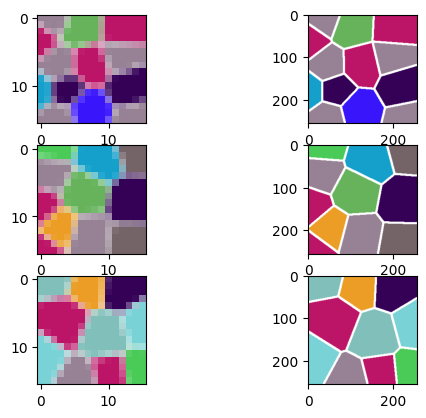

In [4]:
############# Plot Voronoi Low/High Resolution Images ###########
plt.subplot(3,2,1)
plt.imshow(x_train[0])
plt.subplot(3,2,2)
plt.imshow(y_train[0])
print('Number of Voronoi Cells = '+str(y_train_regions[0]))
plt.subplot(3,2,3)
plt.imshow(x_tune[0])
plt.subplot(3,2,4)
plt.imshow(y_tune[0])
print('Number of Voronoi Cells = '+str(y_tune_regions[0]))
plt.subplot(3,2,5)
plt.imshow(x_test[0])
plt.subplot(3,2,6)
plt.imshow(y_test[0])
print('Number of Voronoi Cells = '+str(y_test_regions[0]))

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_generator():
    input_img = layers.Input(shape=(16, 16, 3))  # Input size: 16x16, 3 channels (RGB)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(128, 3, strides=2, padding='same', activation = 'relu')(input_img)
    c2 = layers.Conv2D(256, 3, strides=2, padding='same', activation = 'relu')(c1)
    c3 = layers.Conv2D(512, 3, strides=2, padding='same', activation = 'relu')(c2) 
    
    # bottleneck
    bottleneck = layers.Conv2D(1024, 3, activation='relu', strides=2, padding='same')(c3)      
   
    # Decoder (Upsampling)
    d1 = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation = 'relu')(bottleneck)
    d1 = layers.concatenate([d1, c3])

    d2 = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation = 'relu')(d1)
    d2 = layers.concatenate([d2, c2])
    
    d3 = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation = 'relu')(d2)
    d3 = layers.concatenate([d3, c1])
    
    d4 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation = 'relu')(d3)        
    d5 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation = 'relu')(d4)    
    d6 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation = 'relu')(d5)     
    d7 = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation = 'relu')(d6)
    
    # Output layer
    output = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', strides=2, padding='same')(d7)     
    model = models.Model(inputs=input_img, outputs=output)
    model.summary()        
    return model

def build_discriminator():
    input_image = layers.Input(shape=(256,256,3))
    # Encoder (Downsampling)
    d = layers.Conv2D(32, 4, strides=2, padding='same', activation = 'relu')(input_image)    
    d = layers.Conv2D(64, 4, strides=2, padding='same', activation = 'relu')(d) 
    d = layers.Conv2D(128, 4, strides=2, padding='same', activation = 'relu')(d)      
    d = layers.Conv2D(256, 4, strides=2, padding='same', activation = 'relu')(d)    
    d = layers.Conv2D(512, 4, strides=(2,2), padding='same', activation = 'relu')(d)    
    d = layers.Flatten()(d)
    d = layers.Dense(128, activation = 'relu')(d)
    d = layers.Dropout(0.4)(d)
    d = layers.Dense(128, activation = 'relu')(d)    
    # Output layer
    output = layers.Dense(1, activation='sigmoid')(d)
    model = models.Model(input_image, output)
    model.summary()
    return model

def build_gan(generator, discriminator):    
    lr = layers.Input(shape = (16,16,3))    
    
    fake_img = generator(lr) 
    
    discriminator.trainable = False
    gan_output = discriminator(fake_img)
    
    gan = models.Model(inputs = lr, outputs = [gan_output,fake_img])
    return gan

In [6]:
def mean_squared_error(true, pred):
    mse_loss = tf.reduce_mean(tf.square(tf.subtract(true,pred)))
    return mse_loss

from tqdm import tqdm
def train(discriminator, generator, gan, x_train, y_train, x_tune, y_tune, batch_size, n_epochs):
    train_mse = []
    tune_mse = []
    for i in range(n_epochs):
        no_of_iterations = x_train.shape[0]//batch_size		            
        for j in tqdm(range(no_of_iterations)):

            #discriminator training
            idx = np.random.choice(x_train.shape[0],batch_size)  # select images randomly from training data 
            lr = x_train[idx]  # low res training images  
            hr = y_train[idx]  # high res training images       
            fake_image = generator.predict_on_batch(lr) # generator predictions            
            discriminator.trainable = True
            discriminator.train_on_batch(fake_image, np.zeros((batch_size,1)))	# train discriminator on fake images with zero labels
            discriminator.train_on_batch(hr, np.ones((batch_size,1)))           # train discriminator on real images with one labels

            #gan training (generator training)
            discriminator.trainable = False
            idx = np.random.choice(x_train.shape[0],batch_size)   # select images randomly from training data
            lr = x_train[idx]  # low res training images    
            hr = y_train[idx]  # high res training images                   
            gan.train_on_batch(lr , [np.ones((batch_size,1)),hr])  # train gan on fake images with one labels (fooling the descriminator)                              

        predictions = generator.predict_on_batch(x_train) 
        train_mse.append(mean_squared_error(y_train,predictions).numpy())
        
        predictions = generator.predict_on_batch(x_tune) 
        tune_mse.append(mean_squared_error(y_tune,predictions).numpy())
        print('Epoch = '+str(i+1)+', Train MSE = '+str(train_mse[-1])+', Tune MSE = '+str(tune_mse[-1]))
        
        idx = np.random.choice(x_tune.shape[0],1) 
        lr = x_tune[idx]   
        hr = y_tune[idx]        
        fake_img = generator.predict_on_batch(lr)
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(lr[0])
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(hr[0])
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(fake_img[0])
        plt.axis('off')
        plt.draw()
        plt.pause(0.0001)
    return train_mse, tune_mse

In [7]:
discriminator = build_discriminator()
discriminator.compile(optimizer = 'adam', loss='binary_crossentropy')

generator = build_generator()

gan = build_gan(generator, discriminator)
gan.compile(optimizer = 'adam', loss=['binary_crossentropy','mae'], loss_weights=[1,100])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       524544    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)         2097664   
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0     

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:42<00:00, 18.85it/s]


Epoch = 1, Train MSE = 0.05475223, Tune MSE = 0.055198267


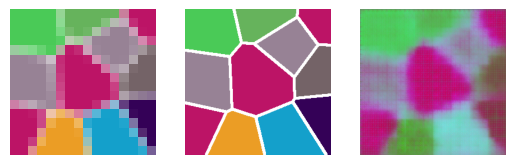

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.54it/s]


Epoch = 2, Train MSE = 0.030008182, Tune MSE = 0.02999896


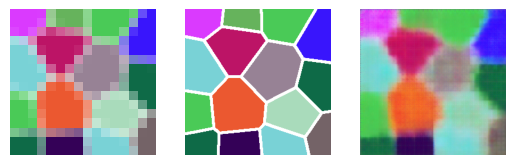

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.48it/s]


Epoch = 3, Train MSE = 0.028755521, Tune MSE = 0.028711544


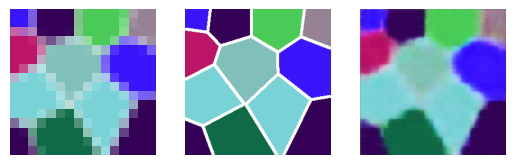

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.41it/s]


Epoch = 4, Train MSE = 0.027285518, Tune MSE = 0.02724271


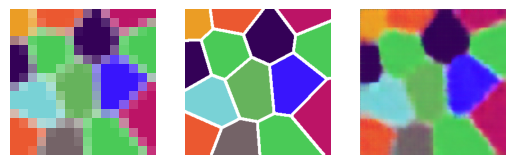

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.49it/s]


Epoch = 5, Train MSE = 0.025233723, Tune MSE = 0.025206268


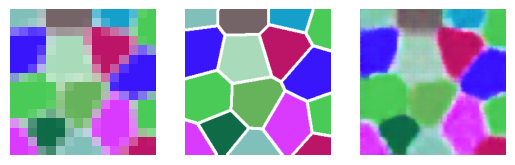

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.32it/s]


Epoch = 6, Train MSE = 0.024068514, Tune MSE = 0.024083177


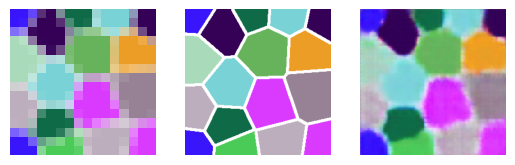

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.57it/s]


Epoch = 7, Train MSE = 0.022439051, Tune MSE = 0.022563444


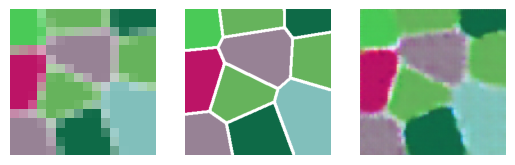

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.82it/s]


Epoch = 8, Train MSE = 0.020730838, Tune MSE = 0.02106066


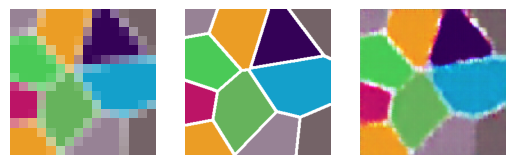

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.85it/s]


Epoch = 9, Train MSE = 0.018905237, Tune MSE = 0.019405272


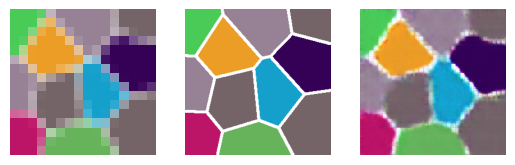

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.84it/s]


Epoch = 10, Train MSE = 0.018273804, Tune MSE = 0.019006103


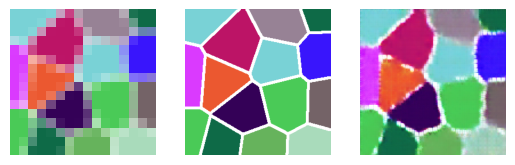

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.43it/s]


Epoch = 11, Train MSE = 0.017281285, Tune MSE = 0.018221196


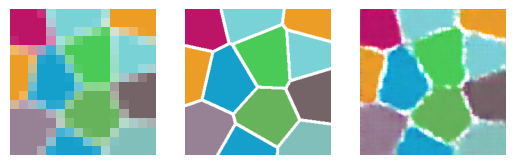

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.86it/s]


Epoch = 12, Train MSE = 0.016196154, Tune MSE = 0.01758007


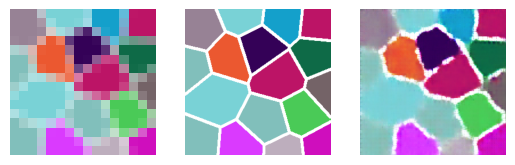

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.36it/s]


Epoch = 13, Train MSE = 0.015711952, Tune MSE = 0.01737061


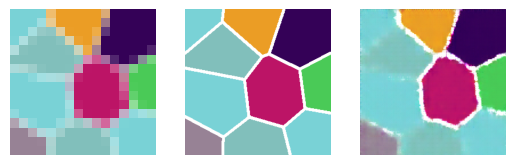

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.77it/s]


Epoch = 14, Train MSE = 0.01548371, Tune MSE = 0.017511839


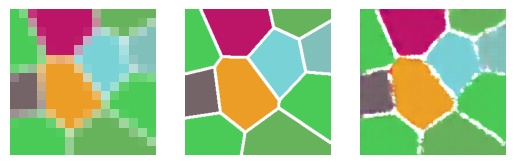

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.73it/s]


Epoch = 15, Train MSE = 0.014554269, Tune MSE = 0.016916862


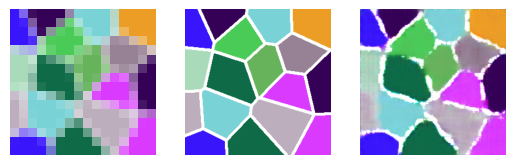

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.77it/s]


Epoch = 16, Train MSE = 0.014167948, Tune MSE = 0.016775692


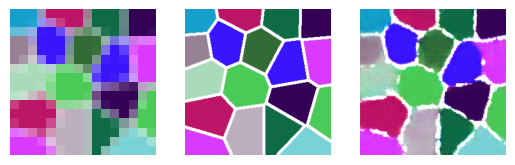

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.31it/s]


Epoch = 17, Train MSE = 0.013655788, Tune MSE = 0.016316274


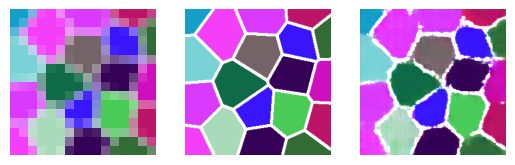

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:37<00:00, 21.06it/s]


Epoch = 18, Train MSE = 0.013629481, Tune MSE = 0.016628163


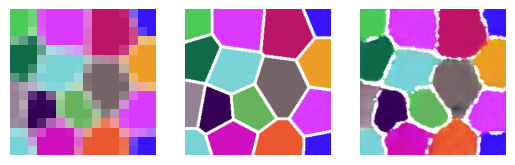

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 21.00it/s]


Epoch = 19, Train MSE = 0.012892827, Tune MSE = 0.015981566


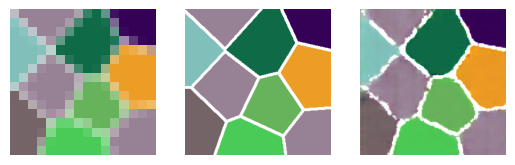

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.63it/s]


Epoch = 20, Train MSE = 0.012900626, Tune MSE = 0.016191356


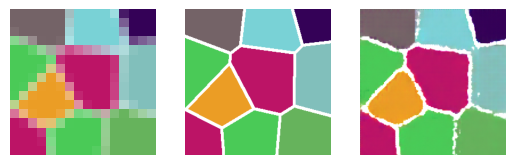

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.74it/s]


Epoch = 21, Train MSE = 0.012693749, Tune MSE = 0.016233016


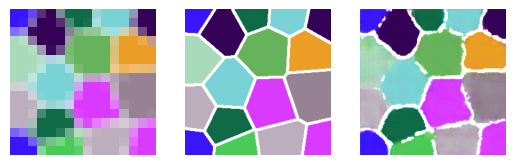

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.68it/s]


Epoch = 22, Train MSE = 0.012493026, Tune MSE = 0.01616798


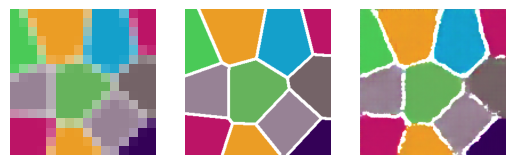

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.71it/s]


Epoch = 23, Train MSE = 0.012276067, Tune MSE = 0.01593041


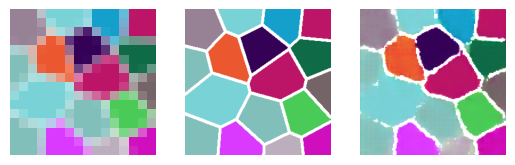

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.51it/s]


Epoch = 24, Train MSE = 0.012149727, Tune MSE = 0.015932316


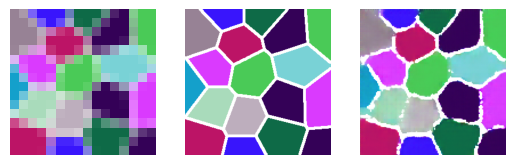

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.80it/s]


Epoch = 25, Train MSE = 0.011996688, Tune MSE = 0.015661668


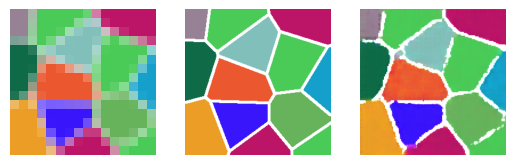

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.43it/s]


Epoch = 26, Train MSE = 0.012040385, Tune MSE = 0.015978958


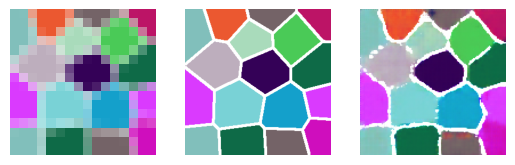

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.60it/s]


Epoch = 27, Train MSE = 0.011973899, Tune MSE = 0.015944062


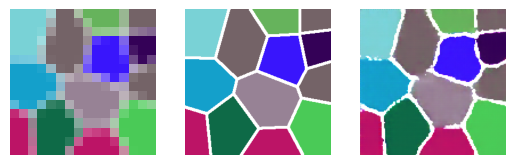

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.56it/s]


Epoch = 28, Train MSE = 0.0118684685, Tune MSE = 0.015844308


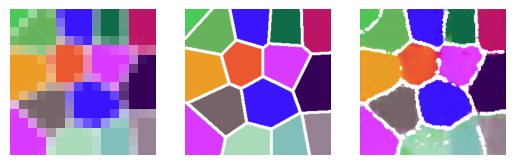

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.87it/s]


Epoch = 29, Train MSE = 0.011778715, Tune MSE = 0.01603577


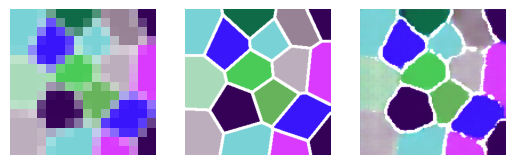

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.87it/s]


Epoch = 30, Train MSE = 0.011333219, Tune MSE = 0.01562987


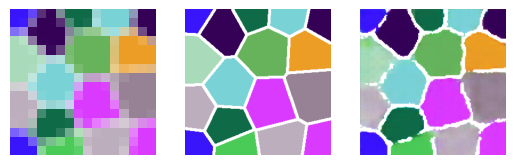

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.53it/s]


Epoch = 31, Train MSE = 0.011347633, Tune MSE = 0.01564433


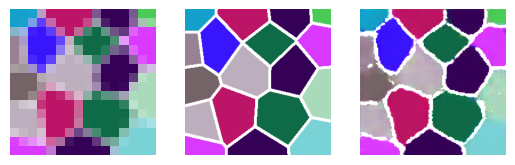

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.87it/s]


Epoch = 32, Train MSE = 0.011287291, Tune MSE = 0.015528663


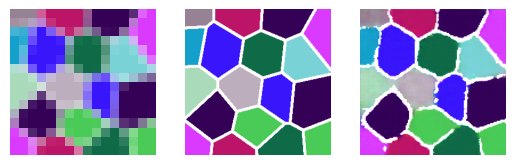

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.87it/s]


Epoch = 33, Train MSE = 0.01141336, Tune MSE = 0.015910184


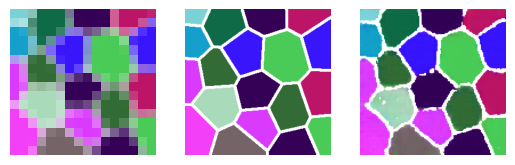

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.27it/s]


Epoch = 34, Train MSE = 0.011287637, Tune MSE = 0.01544171


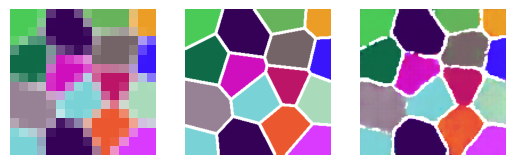

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.74it/s]


Epoch = 35, Train MSE = 0.010997687, Tune MSE = 0.01542539


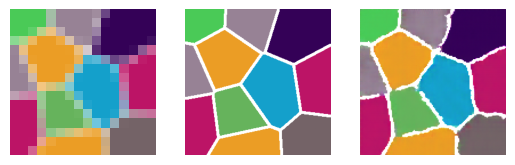

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.51it/s]


Epoch = 36, Train MSE = 0.01076047, Tune MSE = 0.01522031


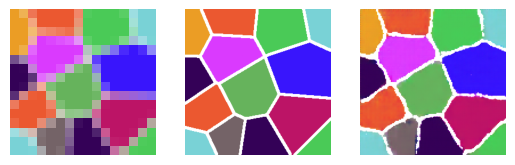

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.63it/s]


Epoch = 37, Train MSE = 0.011050801, Tune MSE = 0.015527948


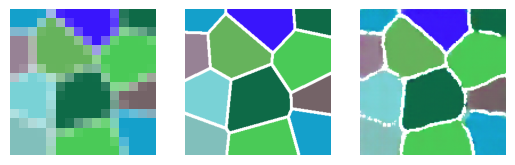

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.78it/s]


Epoch = 38, Train MSE = 0.010710948, Tune MSE = 0.0153602725


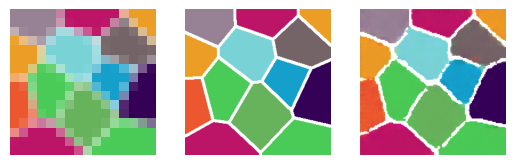

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.71it/s]


Epoch = 39, Train MSE = 0.010685209, Tune MSE = 0.015217554


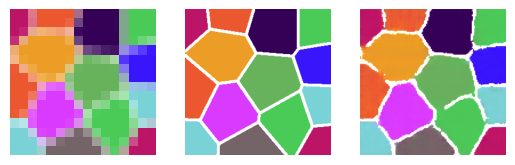

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.81it/s]


Epoch = 40, Train MSE = 0.010705872, Tune MSE = 0.015179944


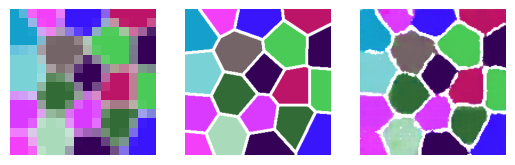

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.66it/s]


Epoch = 41, Train MSE = 0.010325267, Tune MSE = 0.0149524575


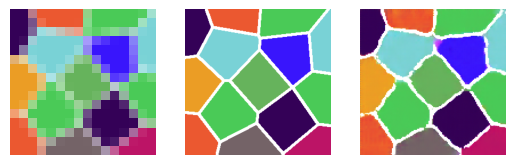

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.67it/s]


Epoch = 42, Train MSE = 0.010641414, Tune MSE = 0.015196805


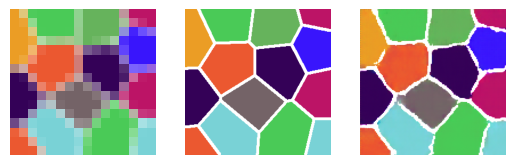

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.49it/s]


Epoch = 43, Train MSE = 0.010569949, Tune MSE = 0.015215705


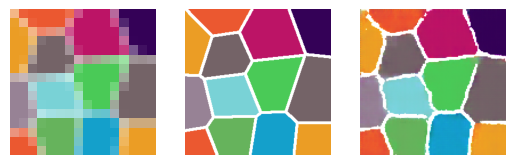

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.77it/s]


Epoch = 44, Train MSE = 0.01080735, Tune MSE = 0.01542278


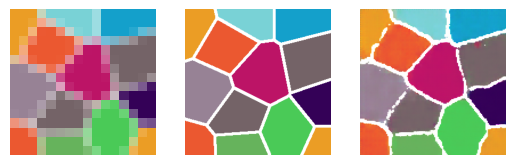

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.76it/s]


Epoch = 45, Train MSE = 0.010509264, Tune MSE = 0.015206375


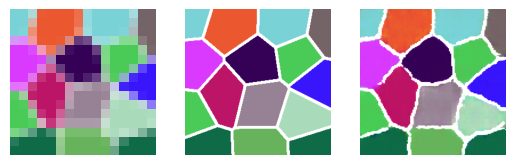

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.84it/s]


Epoch = 46, Train MSE = 0.010116238, Tune MSE = 0.014759973


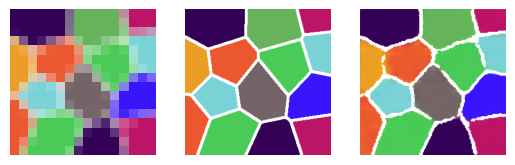

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.82it/s]


Epoch = 47, Train MSE = 0.010095974, Tune MSE = 0.0147668775


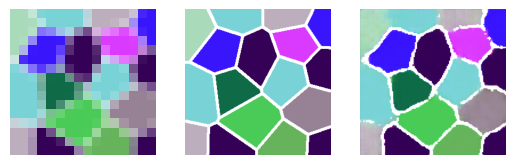

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.87it/s]


Epoch = 48, Train MSE = 0.01006474, Tune MSE = 0.014759795


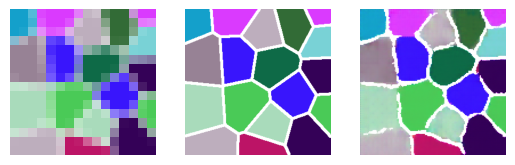

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.81it/s]


Epoch = 49, Train MSE = 0.010111242, Tune MSE = 0.014840902


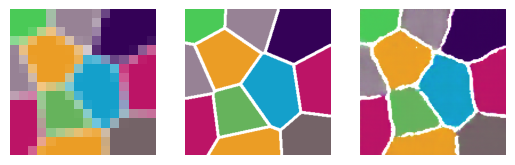

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.30it/s]


Epoch = 50, Train MSE = 0.009899843, Tune MSE = 0.014680942


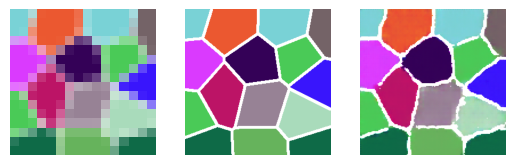

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.78it/s]


Epoch = 51, Train MSE = 0.010023859, Tune MSE = 0.014714048


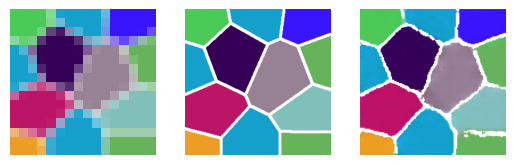

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.75it/s]


Epoch = 52, Train MSE = 0.010080164, Tune MSE = 0.015050384


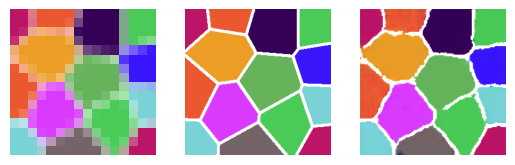

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.76it/s]


Epoch = 53, Train MSE = 0.009878564, Tune MSE = 0.014833716


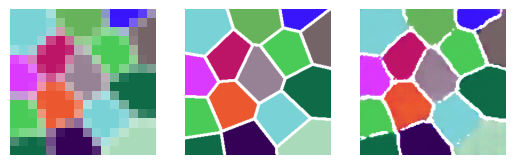

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.79it/s]


Epoch = 54, Train MSE = 0.009502672, Tune MSE = 0.014509404


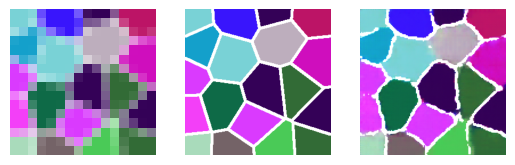

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.83it/s]


Epoch = 55, Train MSE = 0.009727649, Tune MSE = 0.014761695


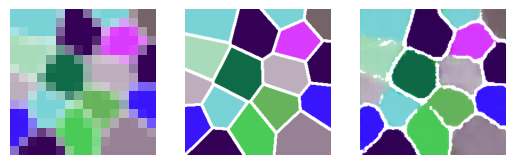

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.75it/s]


Epoch = 56, Train MSE = 0.009629766, Tune MSE = 0.014542823


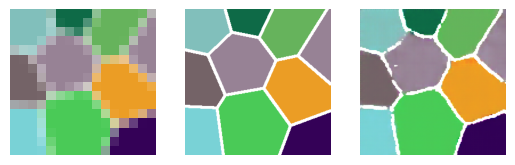

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.63it/s]


Epoch = 57, Train MSE = 0.009427835, Tune MSE = 0.014252982


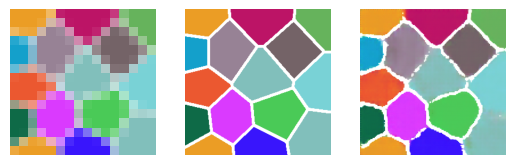

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.22it/s]


Epoch = 58, Train MSE = 0.009429204, Tune MSE = 0.014428341


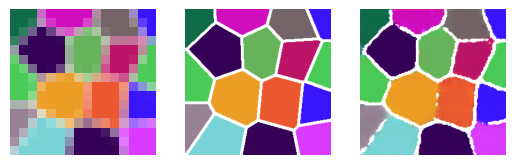

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.45it/s]


Epoch = 59, Train MSE = 0.009466052, Tune MSE = 0.0145539725


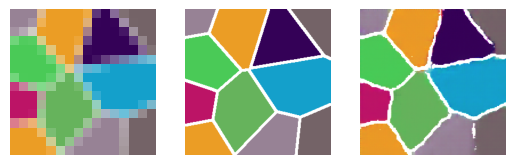

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.77it/s]


Epoch = 60, Train MSE = 0.009508105, Tune MSE = 0.014398802


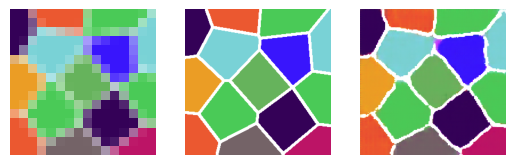

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.58it/s]


Epoch = 61, Train MSE = 0.0092504565, Tune MSE = 0.014313587


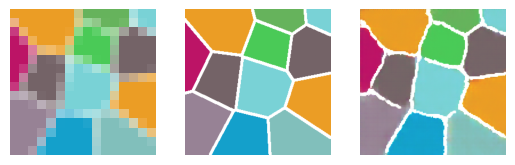

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.69it/s]


Epoch = 62, Train MSE = 0.009654725, Tune MSE = 0.014664772


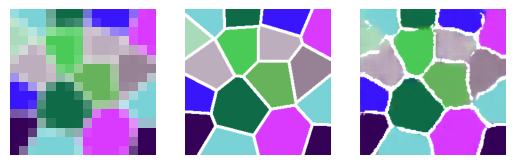

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.78it/s]


Epoch = 63, Train MSE = 0.00922077, Tune MSE = 0.014396301


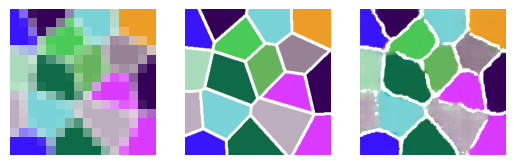

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.76it/s]


Epoch = 64, Train MSE = 0.009061588, Tune MSE = 0.014184907


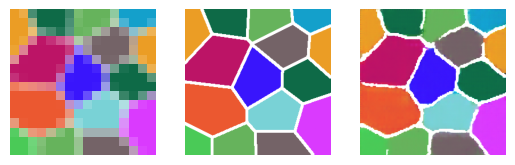

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.80it/s]


Epoch = 65, Train MSE = 0.009293949, Tune MSE = 0.014385532


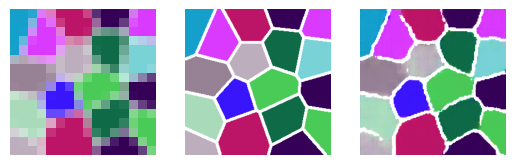

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.74it/s]


Epoch = 66, Train MSE = 0.009315168, Tune MSE = 0.01444242


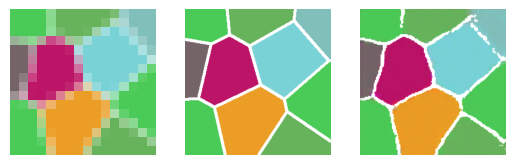

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.76it/s]


Epoch = 67, Train MSE = 0.008950743, Tune MSE = 0.013958974


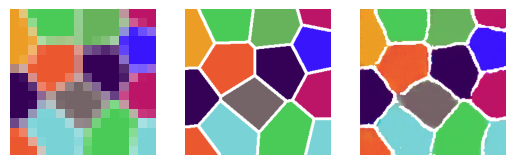

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.83it/s]


Epoch = 68, Train MSE = 0.009225252, Tune MSE = 0.014214869


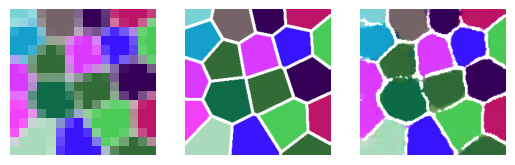

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.67it/s]


Epoch = 69, Train MSE = 0.009240085, Tune MSE = 0.014321626


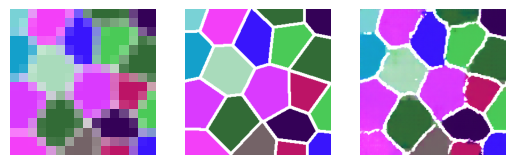

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.81it/s]


Epoch = 70, Train MSE = 0.009073822, Tune MSE = 0.014308173


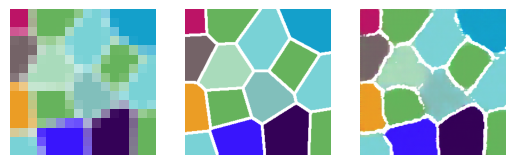

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.75it/s]


Epoch = 71, Train MSE = 0.009203129, Tune MSE = 0.01427726


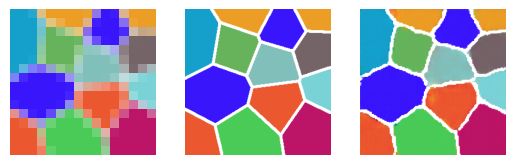

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.74it/s]


Epoch = 72, Train MSE = 0.009125415, Tune MSE = 0.01414945


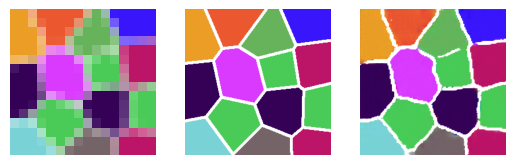

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.37it/s]


Epoch = 73, Train MSE = 0.00905416, Tune MSE = 0.01424571


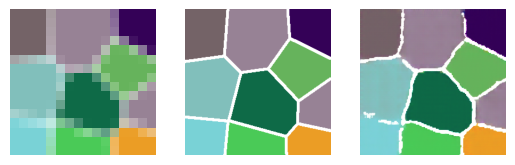

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.72it/s]


Epoch = 74, Train MSE = 0.0090658115, Tune MSE = 0.014300133


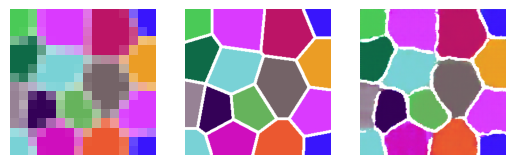

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.73it/s]


Epoch = 75, Train MSE = 0.008902349, Tune MSE = 0.014203153


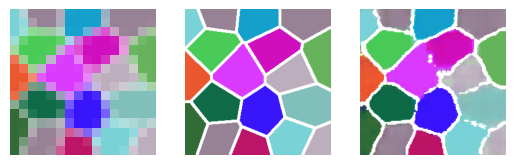

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.56it/s]


Epoch = 76, Train MSE = 0.008929824, Tune MSE = 0.014139025


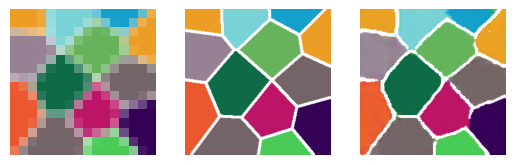

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.23it/s]


Epoch = 77, Train MSE = 0.008702503, Tune MSE = 0.014076055


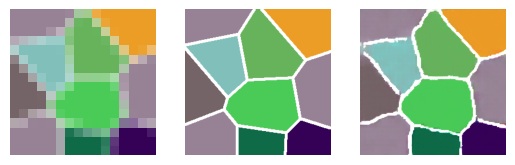

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.95it/s]


Epoch = 78, Train MSE = 0.008883956, Tune MSE = 0.014037915


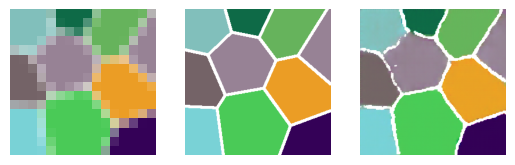

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:37<00:00, 21.13it/s]


Epoch = 79, Train MSE = 0.008948232, Tune MSE = 0.014223871


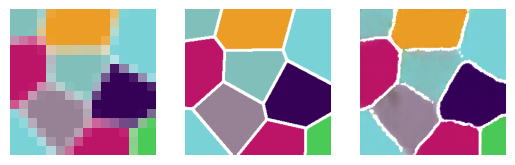

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:37<00:00, 21.09it/s]


Epoch = 80, Train MSE = 0.008822896, Tune MSE = 0.013816136


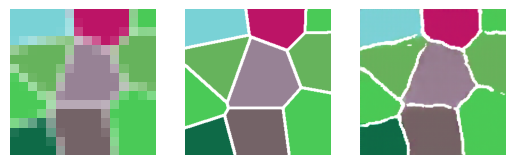

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 21.02it/s]


Epoch = 81, Train MSE = 0.008675047, Tune MSE = 0.013822877


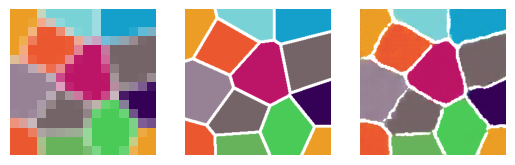

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:37<00:00, 21.10it/s]


Epoch = 82, Train MSE = 0.008772741, Tune MSE = 0.014060863


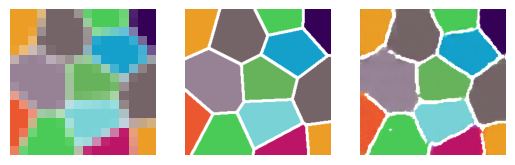

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 21.00it/s]


Epoch = 83, Train MSE = 0.0086991815, Tune MSE = 0.013961518


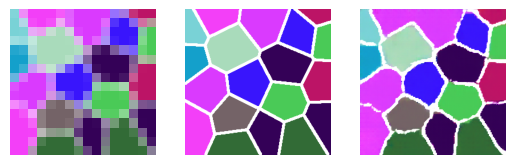

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.54it/s]


Epoch = 84, Train MSE = 0.008502389, Tune MSE = 0.013875782


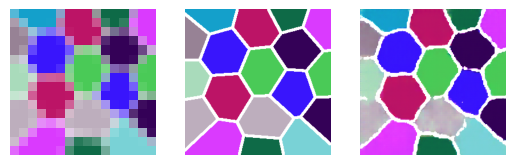

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.73it/s]


Epoch = 85, Train MSE = 0.008649734, Tune MSE = 0.014032859


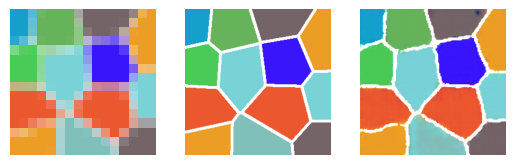

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.67it/s]


Epoch = 86, Train MSE = 0.008378222, Tune MSE = 0.013677737


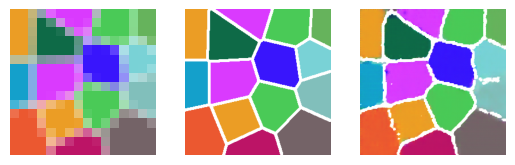

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.71it/s]


Epoch = 87, Train MSE = 0.008196977, Tune MSE = 0.013679426


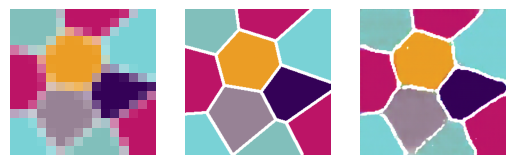

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.73it/s]


Epoch = 88, Train MSE = 0.008081943, Tune MSE = 0.013694986


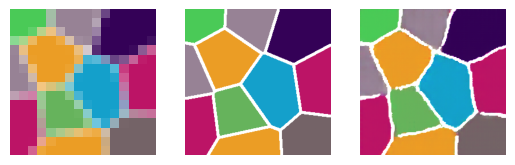

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.66it/s]


Epoch = 89, Train MSE = 0.008083737, Tune MSE = 0.013700591


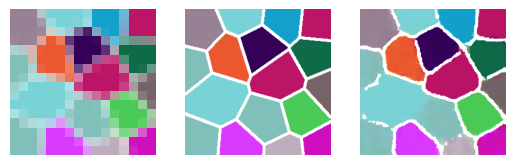

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.50it/s]


Epoch = 90, Train MSE = 0.007773234, Tune MSE = 0.013555786


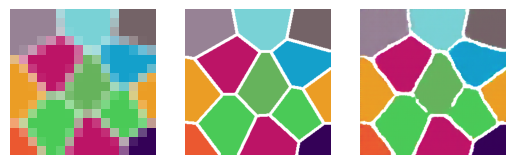

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.55it/s]


Epoch = 91, Train MSE = 0.007599014, Tune MSE = 0.01339856


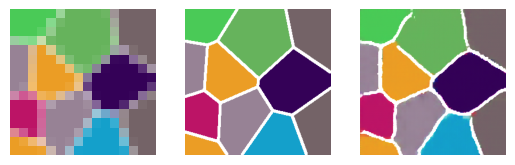

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.73it/s]


Epoch = 92, Train MSE = 0.0075719985, Tune MSE = 0.01355295


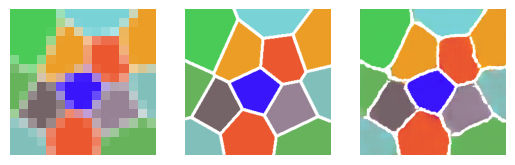

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:38<00:00, 20.74it/s]


Epoch = 93, Train MSE = 0.007423131, Tune MSE = 0.013449941


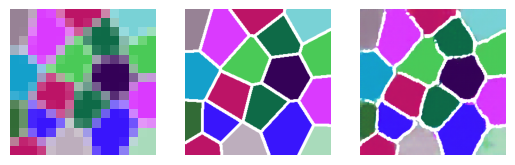

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:40<00:00, 19.99it/s]


Epoch = 94, Train MSE = 0.0075115333, Tune MSE = 0.013694261


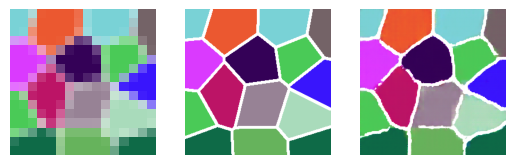

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.39it/s]


Epoch = 95, Train MSE = 0.00745898, Tune MSE = 0.013501797


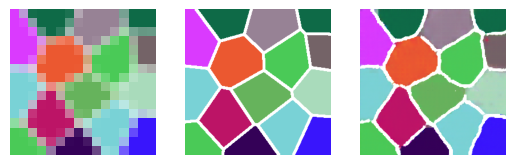

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.48it/s]


Epoch = 96, Train MSE = 0.007465465, Tune MSE = 0.013601985


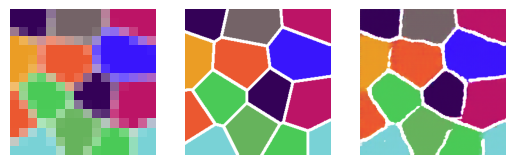

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.01it/s]


Epoch = 97, Train MSE = 0.0075928657, Tune MSE = 0.013773992


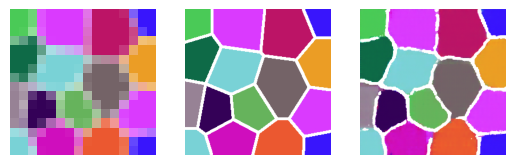

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:40<00:00, 19.54it/s]


Epoch = 98, Train MSE = 0.0074449126, Tune MSE = 0.013605336


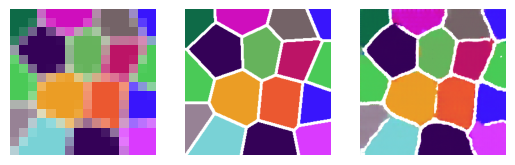

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.25it/s]


Epoch = 99, Train MSE = 0.0074118827, Tune MSE = 0.013558959


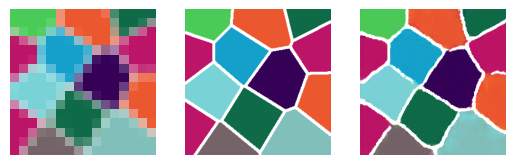

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:39<00:00, 20.50it/s]


Epoch = 100, Train MSE = 0.0074643684, Tune MSE = 0.013715297


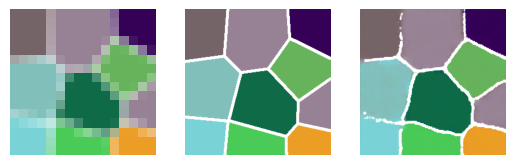

In [8]:
train_mse, tune_mse = train(discriminator, generator, gan, x_train, y_train, x_tune, y_tune, batch_size = 1, n_epochs = 100)

(0.0, 0.06)

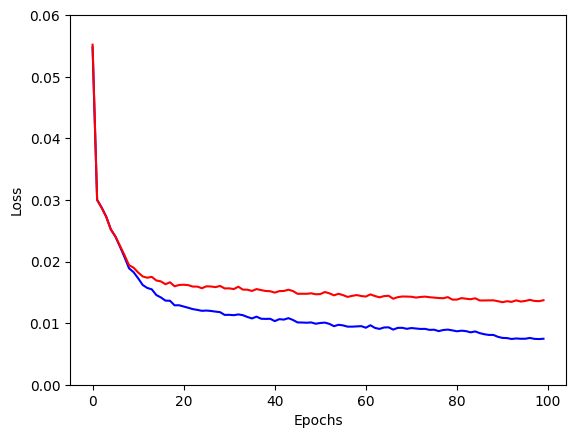

In [10]:
plt.plot(train_mse, c = 'b')
plt.plot(tune_mse, c = 'r')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([0,0.06])

In [12]:
predictions = generator.predict(x_test)

ssim_all = [ssim(y_test[i].squeeze(),predictions[i].squeeze(), channel_axis=-1, data_range=1) for i in range(100)]
print('Average SSIM = '+str(np.mean(ssim_all)))
print('Min SSIM = '+str(np.min(ssim_all)))
print('Max SSIM = '+str(np.max(ssim_all)))
print('STD SSIM = '+str(np.std(ssim_all)))
print('SSIM = '+str(np.round(np.mean(ssim_all),2))+'['+str(np.round(np.percentile(ssim_all,2.5),2))+', '+str(np.round(np.percentile(ssim_all,97.5),2))+'] 95% CI')


Average SSIM = 0.85730165
Min SSIM = 0.7981823
Max SSIM = 0.9059798
STD SSIM = 0.027014447
SSIM = 0.86[0.81, 0.9] 95% CI


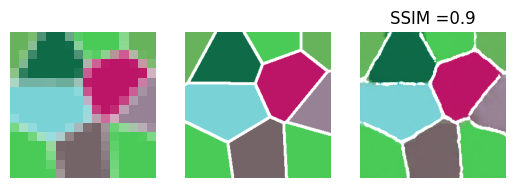

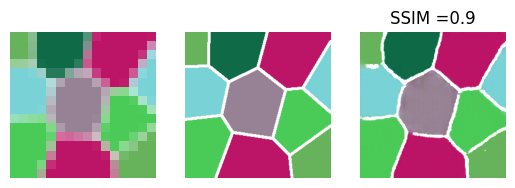

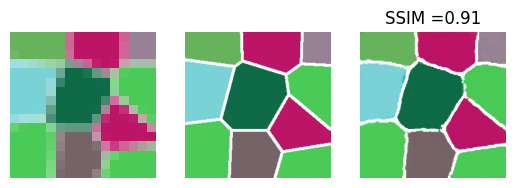

In [15]:
#### 3 best images #####
idx = np.argpartition(ssim_all, -3)[-3:]
for i in idx:  
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(y_test[i])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.title('SSIM ='+str(np.round(ssim_all[i],2)))

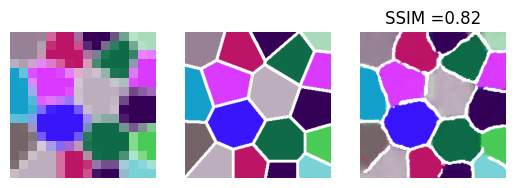

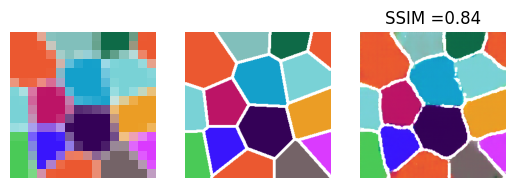

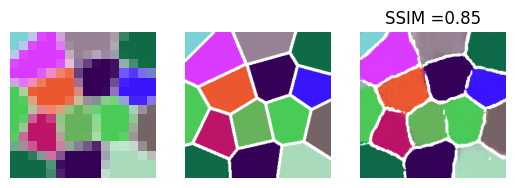

In [16]:
#### 3 worst images #####
idx = np.argpartition(ssim_all, -3)[:3]
for i in idx:  
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(y_test[i])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.title('SSIM ='+str(np.round(ssim_all[i],2)))